![title](dcc_logo.png)
## Digital Curation Centre FAIRsFAIR project example Python Jupyter Notebook to explore the PID Graph. In this example, query the PID graph for a given DMP DOI and display as a tree diagram all of the resources embedded in the Data Management Plan such as the associated datasets, funders, organisations and people.

In [1]:
import json
import pandas as pd
import numpy as np
from dfply import *
import altair.vega.v5 as alt
from altair_saver import save
import requests
from gql import gql, Client
from gql.transport.requests import RequestsHTTPTransport
from IPython.display import display, Markdown
import ipywidgets as widgets

def get_data(id):
    _transport = RequestsHTTPTransport(
        url='https://api.datacite.org/graphql',
        use_json=True,
    )

    client = Client(
        transport=_transport,
        fetch_schema_from_transport=True,
    )    
    
    query_params = {
        "id": id,
        "maxOutputs": 100,
        "minViews": 100
    }

    query = gql("""query getOutputs($id: ID!)
    {
     dataManagementPlan(id: $id) {
        id
        name: titles(first:1) {
          title
        }
        datasets: citations(query:"types.resourceTypeGeneral:Dataset") {
            totalCount
            nodes {
              id: doi
              name: titles(first:1)  {
                title
              }
            }
          }
          publications: citations(query:"types.resourceTypeGeneral:Text") {
            totalCount
            nodes {
              id: doi
              name: titles(first:1)  {
                title
              }
            }
          }
        producer: contributors(contributorType: "Producer") {
          id
          name
          contributorType   
        }   
        fundingReferences {
          id: funderIdentifier
          name: funderName
          award: awardUri
        }
        creators {
          id
          name
          type
          affiliation{
            id
            name
          }
        } 
        pis: contributors(contributorType: "ProjectLeader") {
          id
          name
          contributorType
          affiliation{
            id
            name
          }
        }
        curators: contributors(contributorType: "DataCurator") {
          id
          name
          type
          affiliation{
            id
            name
          }
        }
      }
    }
    """)

    return client.execute(query, variable_values=json.dumps(query_params))["dataManagementPlan"]


def get_affiliation(series_element):
    if len(series_element) == 0:
        return "None"
    return series_element[0]['name']


def add_node_attributes(dataframe, parent=2):
    """Modifies each item to include attributes needed for the node visulisation

    Parameters:
    dataframe (dataframe): A dataframe with all the itemss
    parent (int): The id of the parent node

    Returns:
    dataframe:Returning vthe same dataframe with new attributes

   """
    if (dataframe) is None:
        return pd.DataFrame() 
    else: 
        # print(dataframe) 
        return (dataframe >>
        mutate(
        id = X.id,
        tooltip = X.id,
        parent = parent,
        ))

    
def create_node(array=[], parent=2):
    """creates a node for the chart and formats it

    Parameters:
    array (array): An array with all the itemss
    parent (int): The id of the parent node

    Returns:
    dict:Dict with all the nodes

   """
    # print(array)
    if len(array) == 0:
        return {} 
    else:
        # return {} if (array) is None else array
        df = add_node_attributes(pd.DataFrame(array,columns=array[0].keys()), parent)
        return df.to_dict(orient='records')

    
def merge_nodes(dmpTitle,id,dataset=[],references=[],funders=[],orgs=[],people=[]):
    """Merges all the nodes lists

    Parameters:
    datasets (array): dataset nodes
    funders (array): funders nodes
    orgs (array): orgs nodes
    people (array): people nodes

    Returns:
    array:Array with all the nodes

   """
    dataset = [] if len(dataset) == 0 else dataset
    references = [] if len(references) == 0 else references
    funders = [] if len(funders) == 0 else funders
    orgs = [] if len(orgs) == 0 else orgs
    people = [] if len(people) == 0 else people

    dmp = {"id":id, "name": dmpTitle}
    datasets_node = {"id":2, "name": "Datasets", "parent":id}
    references_node = {"id":6, "name": "Publications", "parent":id}
    funders_node = {"id":3, "name": "Funders", "parent":id}
    organisations_node = {"id":4, "name": "Organisations", "parent":id}
    people_node = {"id":5, "name": "People", "parent":id}
    nodes_list = [dmp, datasets_node, references_node, funders_node,organisations_node,people_node] + dataset + references + funders + orgs + people,
    # return np.array(nodes_list, dtype=object)    
    return nodes_list[0]


def get_title(series_element):
    if len(series_element) == 0:
        return "None"
    return series_element[0]['title']


def extract_titles(list):
    if len(list) == 0:
        return []
    return (pd.DataFrame(list) >> 
        mutate(
             name = X.name.apply(get_title)
        )).to_dict('records')


def vega_template(data):
    """Injects data into the vega specification

    Parameters:
    data (array): Array of nodes

    Returns:
    VegaSpec:Specification with data

   """
    return """
{
  "$schema": "https://vega.github.io/schema/vega/v5.json",
  "description": "An example of a radial layout for a node-link diagram of hierarchical data.",
  "width": 1024,
  "height": 720,
  "padding": 5,
  "autosize": "none",
  "signals": [
    {"name": "Chart", "value": """ +  dmp_title + """, "bind": {"input": "url", "size":100}},
    {"name": "labels", "value": true, "bind": {"input": "checkbox"}},
    {
      "name": "radius",
      "value": 280,
      "bind": {"input": "range", "min": 20, "max": 600}
    },
    {
      "name": "extent",
      "value": 360,
      "bind": {"input": "range", "min": 0, "max": 360, "step": 1}
    },
    {
      "name": "rotate",
      "value": 0,
      "bind": {"input": "range", "min": 0, "max": 360, "step": 1}
    },
    {
      "name": "layout",
      "value": "cluster",
      "bind": {"input": "radio", "options": ["tidy", "cluster"]}
    },
    {
      "name": "links",
      "value": "orthogonal",
      "bind": {
        "input": "select",
        "options": ["line", "curve", "diagonal", "orthogonal"]
      }
    },
    {"name": "originX", "update": "width / 2"},
    {"name": "originY", "update": "height / 2"}
  ],
  "data": [
    {
      "name": "tree",
      "values": """ + data + """,
      "transform": [
        {"type": "stratify", "key": "id", "parentKey": "parent"},
        {
          "type": "tree",
          "method": {"signal": "layout"},
          "size": [1, {"signal": "radius"}],
          "as": ["alpha", "radius", "depth", "children"]
        },
        {
          "type": "formula",
          "expr": "(rotate + extent * datum.alpha + 270) % 360",
          "as": "angle"
        },
        {"type": "formula", "expr": "PI * datum.angle / 180", "as": "radians"},
        {
          "type": "formula",
          "expr": "inrange(datum.angle, [90, 270])",
          "as": "leftside"
        },
        {
          "type": "formula",
          "expr": "originX + datum.radius * cos(datum.radians)",
          "as": "x"
        },
        {
          "type": "formula",
          "expr": "originY + datum.radius * sin(datum.radians)",
          "as": "y"
        }
      ]
    },
    {
      "name": "links",
      "source": "tree",
      "transform": [
        {"type": "treelinks"},
        {
          "type": "linkpath",
          "shape": {"signal": "links"},
          "orient": "radial",
          "sourceX": "source.radians",
          "sourceY": "source.radius",
          "targetX": "target.radians",
          "targetY": "target.radius"
        }
      ]
    }
  ],
  "scales": [
    {
      "name": "color",
      "type": "linear",
      "range": {"scheme": "viridis"},
      "domain": {"data": "tree", "field": "depth"},
      "zero": true
    }
  ],
  "marks": [
    {
      "type": "path",
      "from": {"data": "links"},
      "encode": {
        "update": {
          "x": {"signal": "originX"},
          "y": {"signal": "originY"},
          "path": {"field": "path"},
          "stroke": {"value": "#ccc"}
        }
      }
    },
    {
      "type": "symbol",
      "from": {"data": "tree"},
      "encode": {
        "enter": {
          "size": {"value": 300}, "stroke": {"value": "#fff"}
          },
        "update": {
          "x": {"field": "x"},
          "y": {"field": "y"},
          "fill": {"scale": "color", "field": "depth"}
        }
      }
    },
    {
      "type": "text",
      "from": {"data": "tree"},
      "encode": {
        "enter": {
          "text": {"field": "name"},
          "fontSize": {"value": 12},
          "baseline": {"value": "middle"},
          "tooltip": {"signal": 
          "{'Identifier': datum.tooltip, 'Affiliation': datum.affiliation, 'Contribution': datum.contributorType, 'Award': datum.award}"}
        },
        "update": {
          "x": {"field": "x"},
          "y": {"field": "y"},
          "dx": {"signal": "(datum.leftside ? -1 : 1) * 12"},
          "align": {"signal": "datum.leftside ? 'right' : 'left'"},
          "opacity": {"signal": "labels ? 1 : 0"}
        }
      }
    }
  ]
}

"""

alt.renderers.enable('notebook')

# add a Text input
doi_text_input = widgets.Text(
    value='https://doi.org/10.48321/D17G67',
    placeholder='Type Something',
    description='',
    disabled=False,
    layout=widgets.Layout(width='80%')
)
# TODO - change the style of the labels.
doi_label = widgets.Label(value="Enter below, the DOI of a Data Management Plan to visualise the items connected to it.")
doi_label2 = widgets.Label(value="https://doi.org/10.48321/D17G67 is a valid example of a DMP DOI.")
doi_label3 = widgets.Label(value="After entering/changing the entered DOI, run the next cell to display the visualisation.")
doi_label4 = widgets.Label(value="A warning will be displayed if there is a problem with this DOI.")
doi_input_container = widgets.VBox([doi_label, doi_label2, doi_text_input, doi_label3, doi_label4])

display(doi_input_container)

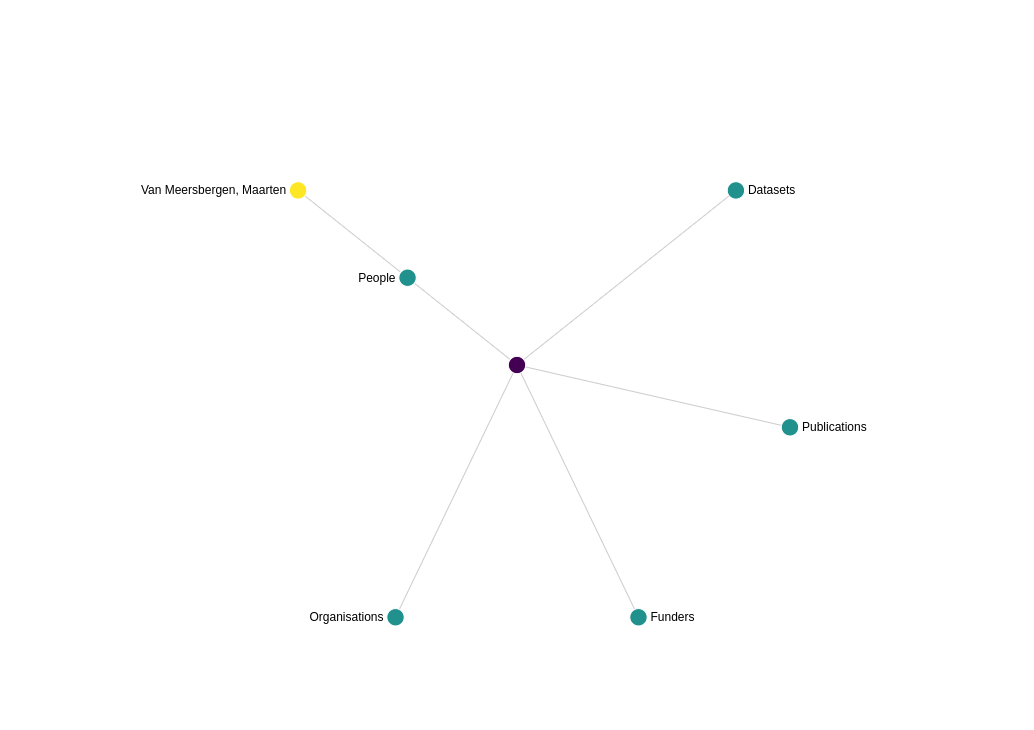

In [3]:
try:
    # TODO maybe we want to validate that what has been entered is like a DOI
    doi_id = doi_text_input.value
    data = get_data(id=doi_id)
    datasets = create_node(extract_titles(data["datasets"]["nodes"]),2)
    references = create_node(extract_titles(data["publications"]["nodes"]),6)
    orgs = create_node(data["producer"],4)
    people = create_node(data["creators"] + data["pis"] + data["curators"],5)
    dmp_title = str('"' + data["name"][0]["title"] + '"')  
    funders = create_node(data["fundingReferences"],3)
    id = data["id"]
    nodes = merge_nodes(" ",id, datasets, references, funders, orgs, people)
    chart = alt.vega(json.loads(vega_template(json.dumps(nodes))))
except Exception as ex:
    print("Warning! - could not retrieve data for this DMP DOI, so unable to display visualisation")